In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tools.tools import add_constant


from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, log_loss

# Learning Curve Functions

In [320]:
def plot_training_curves(model, metric):
    results = model.evals_result_
    
    # Plot training and validation curves
    plt.figure(figsize=(12, 6))
    # Plot training performance
    plt.plot(results['validation_0'][metric], label='Training '+metric)
    plt.plot(results['validation_1'][metric], label='Validation '+metric)
    plt.title('Training and Validation Learning Curves')
    plt.xlabel('Boosting Round')
    plt.ylabel(metric)
    plt.legend()

In [239]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Input Data

In [253]:
df = pd.read_pickle('data.pkl')
df = df[(df['Total']>0)].reset_index(drop = True)[['Sex','Age','Squat','Bench','Dead','Total','Weight','BodyweightKg','AgeGroup']].copy()

<Axes: title={'center': 'Distribution of Age'}, xlabel='Age', ylabel='Count'>

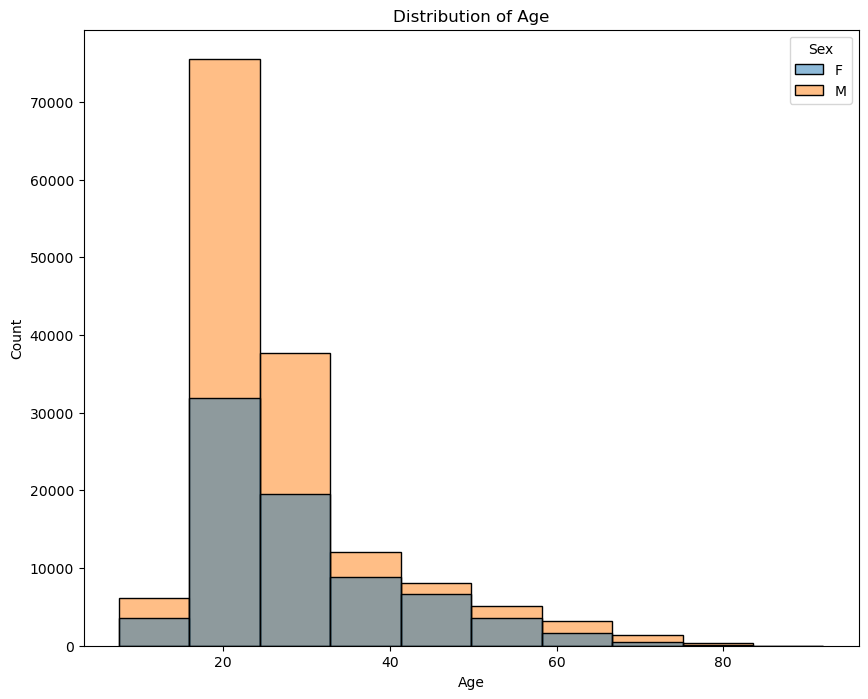

In [254]:
# Plotting the distribution of the target variable
plt.figure(figsize=(10, 8))
plt.title('Distribution of ' + 'Age')
sns.histplot(df, x = 'Age',bins = 10, hue = 'Sex')

<Axes: title={'center': 'Distribution of Age'}, xlabel='AgeGroup', ylabel='0'>

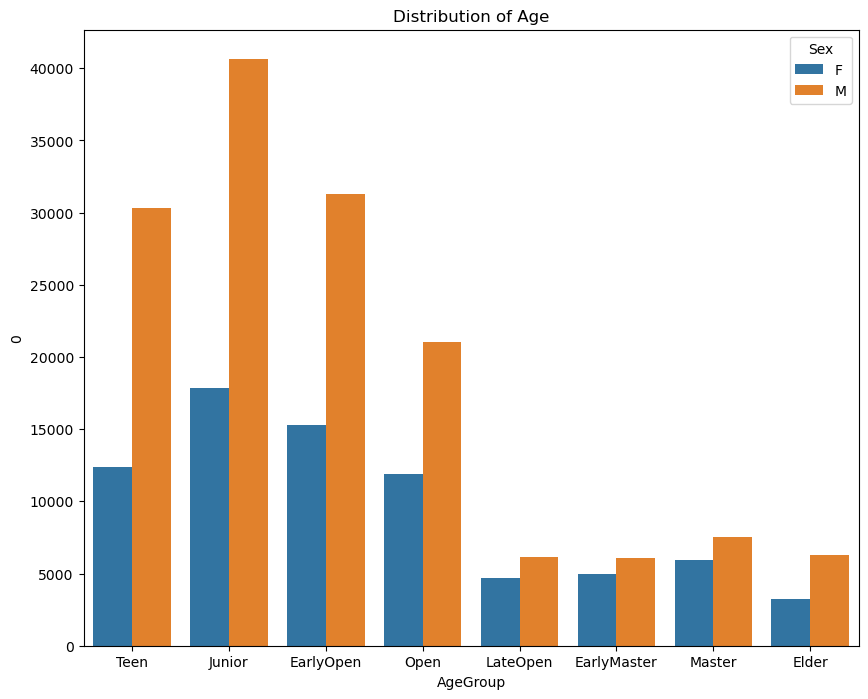

In [255]:
# Plotting the distribution of the target variable
plt.figure(figsize=(10, 8))
plt.title('Distribution of ' + 'Age')
ag_plot = df[['AgeGroup','Sex']].value_counts().sort_index().reset_index()
sns.barplot(x =ag_plot['AgeGroup'], y = ag_plot[0] , hue = ag_plot['Sex'])

# Feature Engineering
- Encoding Sex

In [256]:
df = pd.get_dummies(df,columns = ['Sex'], drop_first = True)

# Predicting Continuous Age Using All Strength Terms

## Generalized Models w/ Continuous Weight Variable
- Independent Variable: Age
- Dependent Variables: Sex, Bodyweight, Squat, Bench, Dead, Total

In [257]:
X = df.drop(['Age','AgeGroup', 'Weight'], axis=1)
y = df['Age']

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=1)

X_train_const = add_constant(X_train)
X_test_const = add_constant(X_test)
X_val_const = add_constant(X_val)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_const)
X_val_scaled = scaler.fit_transform(X_val_const)
X_test_scaled = scaler.fit_transform(X_test_const)

In [ ]:
def regression_metrics(y_test,y_pred):
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    rrmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred)) / y_test.mean()
    #print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    #print('RMAE:', metrics.mean_absolute_error(y_test, y_pred) / y_test.mean())
    #print('EV:', metrics.explained_variance_score(y_test, y_pred))
    r2 = metrics.r2_score(y_test, y_pred)
    return [mse,rmse,rrmse,r2]

def glm_results(model, y_train_linear, y_val_linear, y_test_linear, X_train_scaled, model_type):
    # Plotting Actual vs. Predicted values
    plt.scatter(y_test, y_test_linear)
    plt.plot(y_test, y_test, 'r')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{model_type} Model Predictions')
    plt.show()
    # Display the model equation with coefficients
    if model_type == 'Linear Regression':
        coefficients = model.coef_
        intercept = model.intercept_
        feature_names = X_train_const.columns
        equation = f'Y = {intercept:.2f}'
        for i, coef in enumerate(coefficients):
            equation += f' + {coef:.2f} * {feature_names[i]}'
    elif model_type == 'Polynomial Regression':
        poly_features = model.named_steps['poly_features']
        coefficients = model.named_steps['linear_regression'].coef_
        intercept = model.named_steps['linear_regression'].intercept_
        feature_names = poly_features.get_feature_names_out(X_train.columns)
        equation = f'Y = {intercept:.2f}'
        for i, coef in enumerate(coefficients):
            equation += f' + {coef:.2f} * {feature_names[i]}'
    
    
    # Evaluate the model
    print(f'{model_type} Model Metrics:')
    train_val_test =pd.DataFrame([regression_metrics(y_train, y_train_linear), regression_metrics(y_val, y_val_linear), regression_metrics(y_test, y_test_linear)], 
                                 columns = ['MSE','RMSE','RRMSE','R2'], index = ['Train', 'Validation', 'Test']).T
    print(train_val_test)
    print(equation)
    
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='neg_mean_squared_error')
    print('Cross-Validation RMSE:', np.sqrt(-cv_scores.mean()))
    plot_learning_curve(model, 'Learning Curve', X_train_scaled, y_train, cv=3, n_jobs=-1)

### Linear Regression

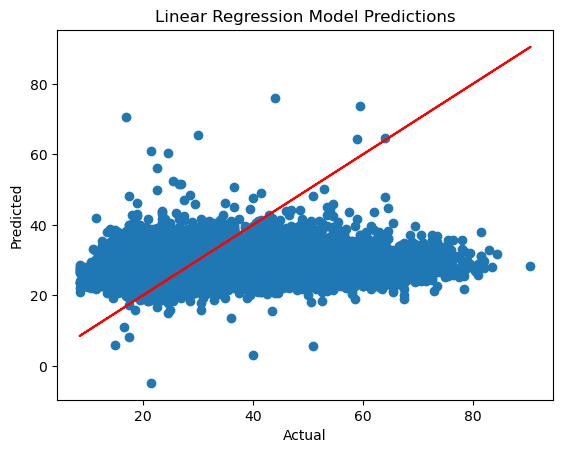

Linear Regression Model Metrics:
            Train  Validation        Test
MSE    126.877850  127.972719  127.129079
RMSE    11.264007   11.312503   11.275153
RRMSE    0.406380    0.407748    0.406178
R2       0.066871    0.061721    0.067730
Y = 27.72 + 0.00 * const + -5.33 * Squat + 3.77 * Bench + 1.03 * Dead + -0.59 * Total + 2.90 * BodyweightKg + -1.75 * Sex_M
Cross-Validation RMSE: 11.264408488857148


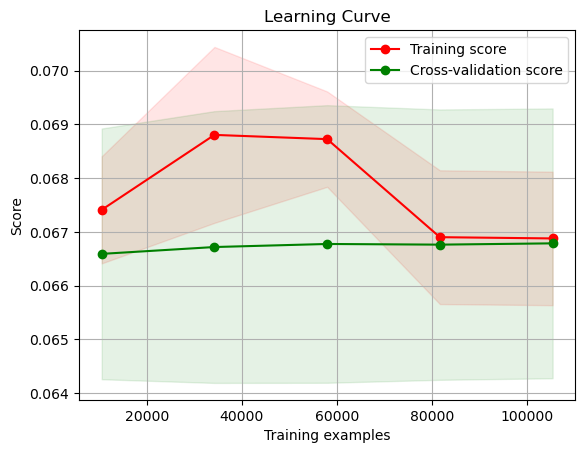

In [ ]:
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
y_train_linear = lm.predict(X_train_scaled)
y_val_linear = lm.predict(X_val_scaled)
y_test_linear = lm.predict(X_test_scaled)
glm_results(lm,y_train_linear, y_val_linear, y_test_linear, X_train_scaled, 'Linear Regression')

### Polynomial Regression (degree = 3)

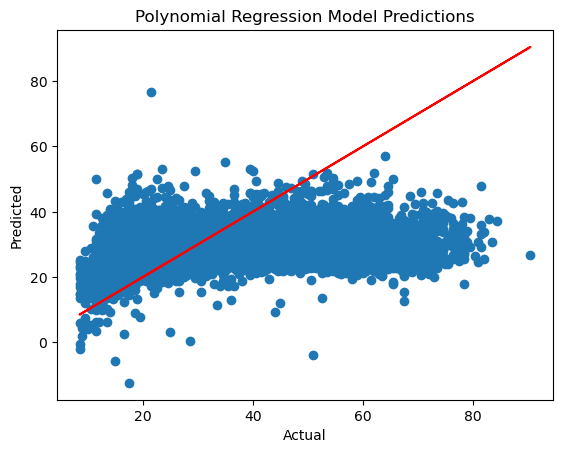

Polynomial Regression Model Metrics:
            Train  Validation        Test
MSE    122.683007  124.095307  122.728947
RMSE    11.076236   11.139807   11.078310
RRMSE    0.399605    0.401524    0.399087
R2       0.097722    0.090149    0.099998
Y = -6.18 + 0.00 * 1 + -257.09 * Squat + -256.52 * Bench + -256.44 * Dead + 256.79 * Total + 0.62 * BodyweightKg + -9.11 * Sex_M + 9.23 * Squat^2 + 11.91 * Squat Bench + 12.69 * Squat Dead + 0.60 * Squat Total + 10.85 * Squat BodyweightKg + 1.54 * Squat Sex_M + 2.68 * Bench^2 + 6.13 * Bench Dead + 7.15 * Bench Total + 10.85 * Bench BodyweightKg + 0.25 * Bench Sex_M + 3.46 * Dead^2 + 6.37 * Dead Total + 10.85 * Dead BodyweightKg + 0.09 * Dead Sex_M + -9.83 * Total^2 + -10.85 * Total BodyweightKg + -0.26 * Total Sex_M + -0.00 * BodyweightKg^2 + 0.17 * BodyweightKg Sex_M + -7.11 * Sex_M^2 + -406.01 * Squat^3 + -493.97 * Squat^2 Bench + 46.69 * Squat^2 Dead + -1337.21 * Squat^2 Total + -657.37 * Squat^2 BodyweightKg + 0.67 * Squat^2 Sex_M + 565.23

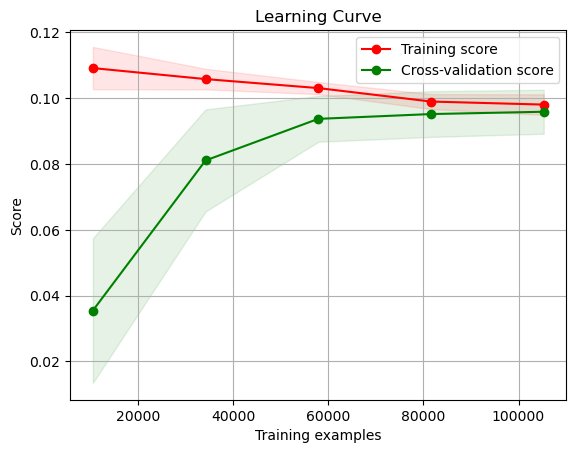

In [ ]:
degree = 3

# Create a pipeline with polynomial features and linear regression
plm = Pipeline([
    ('poly_features', PolynomialFeatures(degree=degree)),
    ('linear_regression', LinearRegression())
])

# Fit the polynomial model
plm.fit(X_train, y_train)

# Make predictions
y_test_poly = plm.predict(X_test)
y_val_poly = plm.predict(X_val)
y_train_poly = plm.predict(X_train)
glm_results(plm,y_train_poly, y_val_poly, y_test_poly, X_train, 'Polynomial Regression')

## Tree Model (XGBoost) w/ Continuous Weight Variable
- Independent Variable: Age
- Dependent Variables: Sex, Bodyweight, Squat, Bench, Dead, Total

In [266]:
def xgb_results(model, y_train_xgb, y_val_xgb, y_test_xgb, X_train, metric):
    # Plotting Actual vs. Predicted values
    plt.scatter(y_test, y_test_xgb)
    plt.plot(y_test, y_test, 'r')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'XGB Model Predictions')
    plt.show()
    
    # Evaluate the model
    print(f'XGB Model Metrics:')
    train_val_test =pd.DataFrame([regression_metrics(y_train, y_train_xgb), regression_metrics(y_val, y_val_xgb), regression_metrics(y_test, y_test_xgb)], 
                                 columns = ['MSE','RMSE','RRMSE','R2'], index = ['Train', 'Validation', 'Test']).T
    print(train_val_test)   
    plot_training_curves(model,metric)

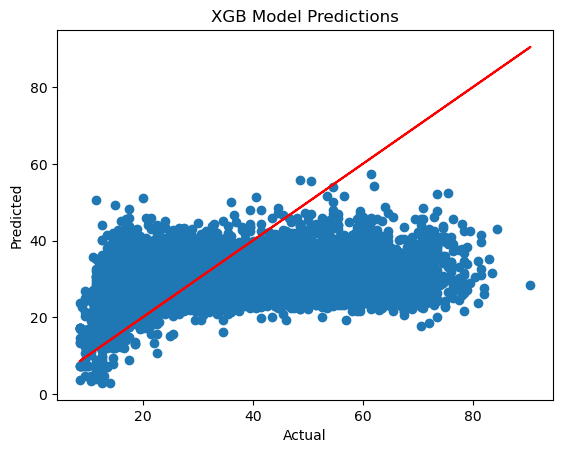

XGB Model Metrics:
            Train  Validation        Test
MSE    120.425694  122.049050  121.016131
RMSE    10.973864   11.047581   11.000733
RRMSE    0.395912    0.398199    0.396292
R2       0.114324    0.105152    0.112558


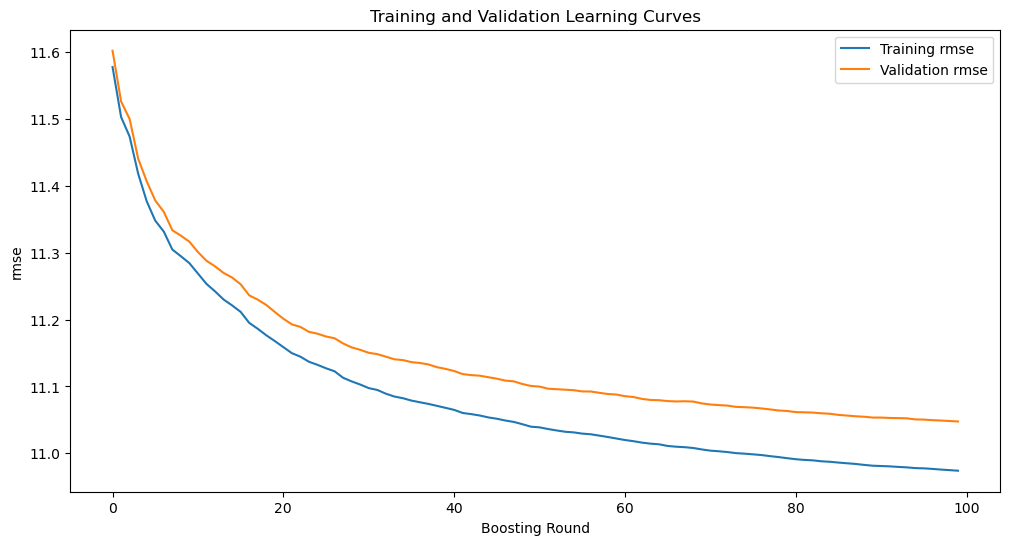

In [290]:
xgb = XGBRegressor(n_jobs = -1, eval_metric = 'rmse', n_estimators = 100,
                    early_stopping_rounds = 3, max_depth = 2, random_state=1)
xgb.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), # training set included for plotting training curves
                    (X_val, y_val)], verbose = False) 
y_train_xgb = xgb.predict(X_train)
y_val_xgb = xgb.predict(X_val)
y_test_xgb = xgb.predict(X_test)

xgb_results(xgb,y_train_xgb, y_val_xgb, y_test_xgb, X_train,'rmse')

# Predicting Age Group Using All Strength Terms

In [400]:
def predict(X_train, X_val, X_test, model):
    test_prob = model.predict_proba(X_test)
    test_pred = np.argmax(test_prob, axis=1)
    train_prob = model.predict_proba(X_train)
    train_pred = np.argmax(train_prob, axis=1)
    val_prob = model.predict_proba(X_val)
    val_pred = np.argmax(val_prob, axis=1)
    return test_pred, test_prob,train_pred,train_prob, val_pred, val_prob

def cfm_metrics(test_cfm):
    positive = np.sum(np.diag(test_cfm))
    total_samples = np.sum(test_cfm)
    negative = total_samples - positive
    return positive, negative
def classification_results(y_test, y_train, y_val, model,xgb_train_prob, xgb_val_prob, xgb_test_prob,xgb_test_pred, xgb_val_pred, xgb_train_pred, metric):
  test_cfm = confusion_matrix(y_test,xgb_test_pred)
  val_cfm = confusion_matrix(y_val,xgb_val_pred)
  train_cfm = confusion_matrix(y_train,xgb_train_pred)

  train_cfm_summary = cfm_metrics(train_cfm)
  test_cfm_summary = cfm_metrics(test_cfm)
  val_cfm_summary = cfm_metrics(val_cfm)

  train_val_test =pd.DataFrame([[train_cfm_summary[0]/(train_cfm_summary[1]+train_cfm_summary[0]),log_loss(y_train, xgb_train_prob),roc_auc_score(y_train, xgb_train_prob, multi_class='ovr')],
                                  [val_cfm_summary[0]/(val_cfm_summary[1]+val_cfm_summary[0]),log_loss(y_val, xgb_val_prob),roc_auc_score(y_val, xgb_val_prob, multi_class='ovr')],
                                  [test_cfm_summary[0]/(test_cfm_summary[1]+test_cfm_summary[0]),log_loss(y_test, xgb_test_prob),roc_auc_score(y_test, xgb_test_prob, multi_class='ovr')]], 
                              columns = ['Accuracy', 'Log Loss','ROC_AUC'], index = ['Train', 'Validation', 'Test']).T
  print(train_val_test)
  plot_training_curves(model,metric)
  print('Training: ')
  print(classification_report(y_train, xgb_train_pred))
  print('Validation: ')
  print(classification_report(y_val, xgb_val_pred))
  print('Testing: ')
  print(classification_report(y_test, xgb_test_pred))

## Tree (XGBoost) Models w/ Continuous Weight Variable
- Independent Variable: AgeGroup
- Dependent Variables: Sex, Bodyweight, Squat, Bench, Dead, Total

In [299]:
X = df.drop(['Age','AgeGroup', 'Weight'], axis=1)
y = pd.factorize(df['AgeGroup'])[0]

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=1)

             Train  Validation      Test
Accuracy  0.330622    0.325967  0.329335
Log Loss  1.702984    1.716692  1.709567
ROC_AUC   0.692566    0.680226  0.686171
Training: 
              precision    recall  f1-score   support

           0       0.69      0.00      0.00      7666
           1       0.41      0.52      0.46     30068
           2       0.31      0.66      0.42     40850
           3       0.32      0.21      0.25     32459
           4       0.31      0.09      0.14      6663
           5       0.25      0.10      0.14     23104
           6       0.23      0.04      0.06      9445
           7       0.37      0.00      0.00      7696

    accuracy                           0.33    157951
   macro avg       0.36      0.20      0.18    157951
weighted avg       0.34      0.33      0.28    157951

Validation: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1590
           1       0.40      0.52      0.45      638

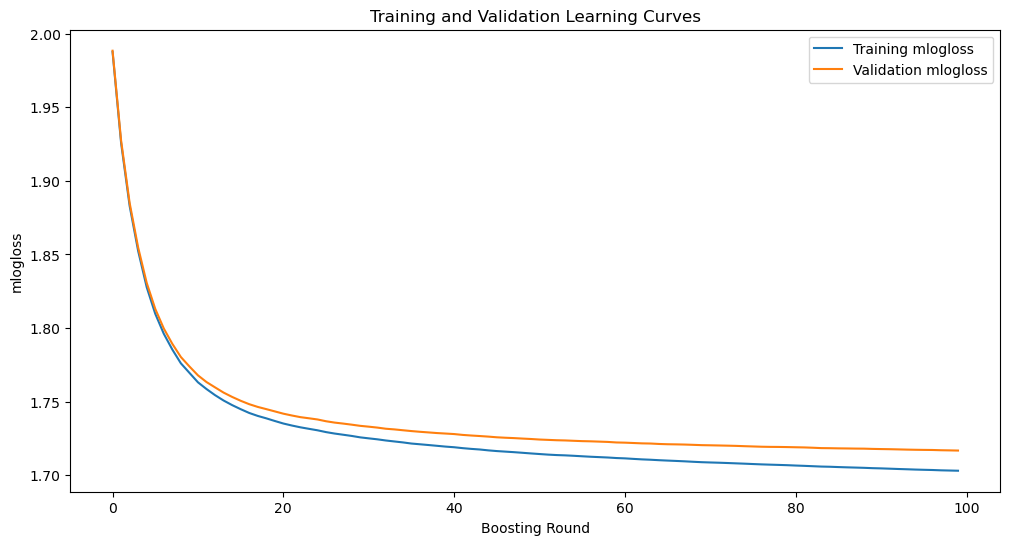

In [401]:
# Train an XGBoost multi-class classifier
xgb_clf = XGBClassifier(objective='multi:softmax', num_class=8, n_estimators=100,
                            early_stopping_rounds = 3, max_depth = 2, random_state=1, eval_metric = 'mlogloss')
xgb_clf.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), # training set included for plotting training curves
                    (X_val, y_val)], verbose = False)
xgb_test_pred, xgb_test_prob, xgb_train_pred, xgb_train_prob, xgb_val_pred, xgb_val_prob = predict(X_train, X_val, X_test, xgb_clf)
classification_results(y_test, y_train, y_val, xgb_clf,xgb_train_prob, xgb_val_prob, xgb_test_prob,xgb_test_pred, xgb_val_pred, xgb_train_pred,'mlogloss')